In [2]:
import os
os.chdir("D:\\אוניברסיטה\\מעבדה\\Project - Maya\\Anomaly_Detection_In_Microbiome_Proj")
import sys
import pandas as pd
import numpy as np
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import MicrobiomeIsolationForest
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import copy
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu
from sklearn import ensemble
from sklearn.metrics import roc_auc_score
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.ensemble import IsolationForest
import datetime

from joblib import Parallel, delayed
from multiprocessing import cpu_count

from sklearn.mixture import GaussianMixture
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
res_franzosa = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/franzosa/mini_results/mini_franzosa_results", 100, [1, 2,3, 4, 5, 10, 15, 20, 25])
res_mp_m3 = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/moving pictures/mini_results/mini_mp_results_M3_normal", 10, [1, 2,3, 4, 5, 10, 15,20, 25])
res_mp_f4 = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/moving pictures/mini_results/mini_mp_results_F4_normal", 10, [1, 2,3, 4, 5, 10, 15,20, 25])
res_yachida = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/YACHIDA_CRC_2019/mini_results/mini_yachida_results", 100, [1, 2,3, 4, 5, 10, 15, 20, 25])
res_hmp = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/hmp/mini_results/mini_hmp_results", 150, [1, 2,3, 4, 5, 10, 15, 20, 25])
res_wang = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/wang/results/mini_wang_results", 100, [1, 2,3, 4, 5, 10, 15, 20, 25])



C:\Users\Omri\AppData\Local\Temp\ipykernel_44748\4253370468.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_res = {outlier_num : pd.read_csv(location + "_50_%i.csv" % outlier_num, index_col=0) for outlier_num in num_of_outliers}


In [5]:
auc_df = add_auc(res_franzosa, "franzosa")
depth_df = add_depth(res_franzosa, "franzosa")

auc_df = add_auc(res_mp_m3, "mp_m3", auc_df)
depth_df = add_depth(res_mp_m3, "mp_m3", depth_df)

auc_df = add_auc(res_mp_f4, "mp_f4", auc_df)
depth_df = add_depth(res_mp_f4, "mp_f4", depth_df)


# auc_df = add_auc(res_yachida, "yachida", auc_df)
# depth_df = add_depth(res_yachida, "yachida", depth_df)

auc_df = add_auc(res_wang, "Wang", auc_df)
depth_df = add_depth(res_wang, "Wang", depth_df)

auc_df = add_auc(res_hmp, "hmp", auc_df)
depth_df = add_depth(res_hmp, "hmp", depth_df)

depth_df.reset_index(drop=True, inplace=True)
auc_df["anomaly_precentage"] = auc_df["num_of_anomalies"] * 2
depth_df["anomaly_precentage"] = depth_df["anomaly_num"] * 2

auc_df

,dataset,mifo_iso,num_of_anomalies,score,anomaly_precentage
0,franzosa,KADAIF,1,0.860211,2
1,franzosa,IF,1,0.505959,2
2,franzosa,CLOUD,1,0.82198,2
3,franzosa,KADAIF,2,0.886499,4
4,franzosa,IF,2,0.547922,4
...,...,...,...,...,...
130,hmp,IF,20,0.204534,40
131,hmp,CLOUD,20,0.426264,40
132,hmp,KADAIF,25,0.619574,50
133,hmp,IF,25,0.153114,50


In [6]:
auc_df[auc_df["dataset"] == "hmp"]
auc_df.replace("mifo", "KADAIF", inplace = True)
auc_df.replace("iso", "IF", inplace = True)
auc_df.columns = ["dataset", "Method", "num_of_anomalies", "AUC", "Anomaly percentage"]
auc_df = auc_df.replace("franzosa", "Franzosa").replace("yachida", "Yachida").replace("hmp", "HMP").replace("mp_m3", "Caporaso M3").replace("mp_f4", "Caporaso F4")
depth_df = depth_df.replace("franzosa", "Franzosa").replace("yachida", "Yachida").replace("hmp", "HMP").replace("mp_m3", "Caporaso M3").replace("mp_f4", "Caporaso F4")

In [45]:
palette = {50: "#CAF0F8", 40: "#ADE8F4", 30: "#90E0EF", 20: "#48CAE4", 10: "#48CAE4", 
                             8: "#00B4D8", 6: "#0096C7", 4: "#0077B6", 2: "#023E8A", "Normal": "#FF2B1B",
           "Normal 20%": "#fad5d2", "Normal 10%": "#d6a5a1", "Normal 8%": "#a36e6a", 
           "Normal 6%": "#91524d", "Normal 4%": "#7a3731", "Normal 2%": "#450601"}


<Figure size 1000x2000 with 0 Axes>

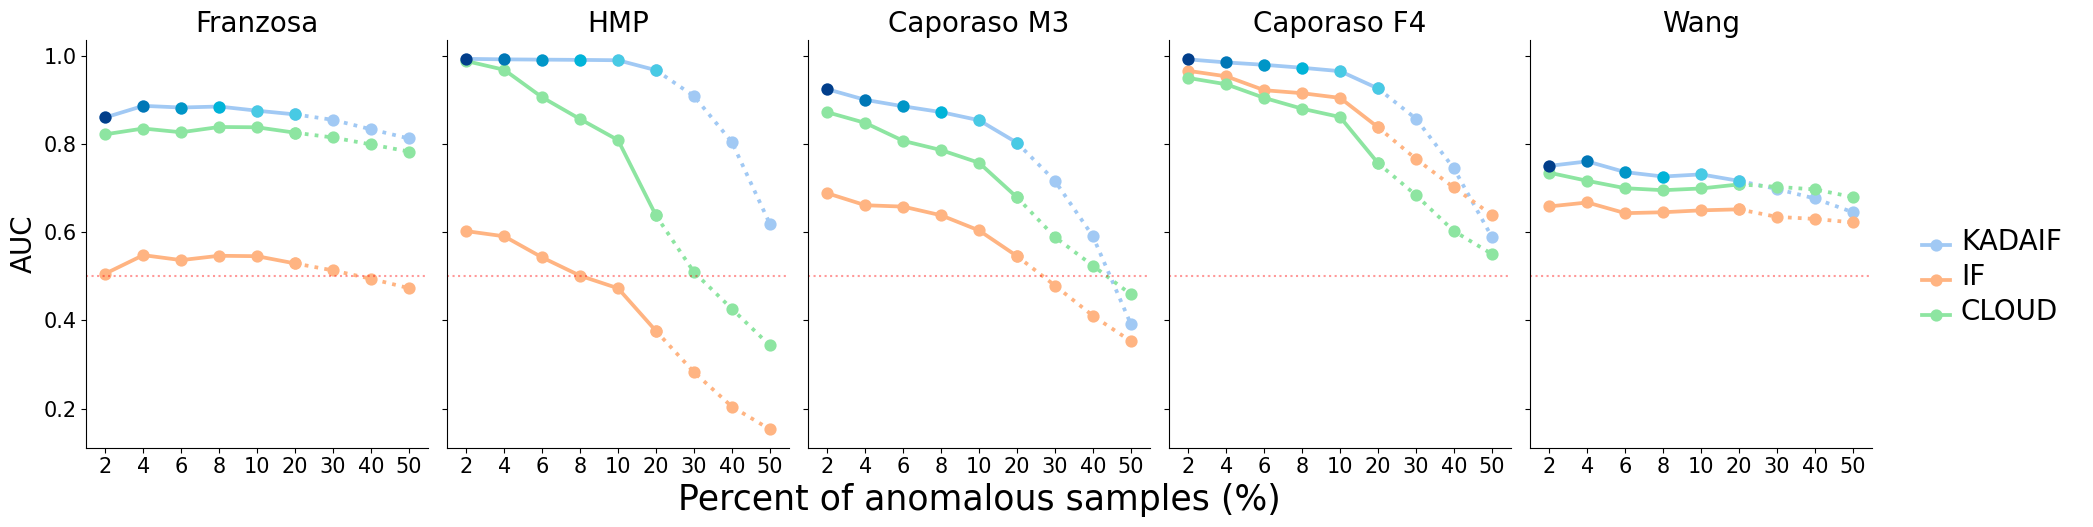

In [8]:
auc_df["Anomaly percentage"] = auc_df["Anomaly percentage"].astype(int)
tmp_auc_df = auc_df[auc_df["Anomaly percentage"] <= 20]
tmp_auc_df2 = auc_df[auc_df["Anomaly percentage"] >= 20]
plt.figure(figsize=(10,20))
g = sns.catplot(x="Anomaly percentage", y="AUC", hue="Method", col="dataset", kind = "point",
                aspect=0.75, palette = "pastel", errorbar = "sd", col_order= ["Franzosa", "HMP", "Caporaso M3", "Caporaso F4", "Wang"],
               data=tmp_auc_df)

for ax, col_name in zip(g.axes.flat, g.col_names):
    sns.pointplot(
        x="Anomaly percentage", y="AUC", hue="Method", data=tmp_auc_df2[tmp_auc_df2["dataset"] == col_name],
        ax=ax, palette="pastel", errorbar="sd", linestyles="dotted"
    )
    for anomal_perc in [2,4, 6, 8, 10, 20]:
        sns.pointplot(
        x="Anomaly percentage", y="AUC", 
            data=tmp_auc_df[(tmp_auc_df["dataset"] == col_name) & (tmp_auc_df["Anomaly percentage"] == anomal_perc) & (tmp_auc_df["Method"] == "KADAIF")],
            ax=ax,  errorbar="sd", color= palette[anomal_perc]
    )

g.set_titles("{col_name}", size=20)  # Here, 'col_name' will be replaced by the value of the dataset column


# Increase the font size for the axis ticks
counter = 0
for ax in g.axes.flat:
    ax.tick_params(labelsize= 15)  

    # Increase the axis title size
      # Set the size of the x-axis title
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    if counter == 2:
        ax.set_xlabel("Percent of anomalous samples (%)", fontsize=25)
    else:
        ax.set_xlabel("", fontsize=0)
    counter += 1

    ax.legend_.remove()
    ax.axhline(y = 0.5, color = 'r', linestyle = 'dotted', alpha = 0.4) 

plt.ylabel("AUC", fontsize = 20)
    
g._legend.set_title("", prop={'size': 0})
for text in g._legend.texts:
    text.set_fontsize('20')  # Set text fontsize
g._legend.set_bbox_to_anchor((1.05, 0.5))  # Moves the legend to the right of the figure
# for handle in g._legend.legendHandles:
    # handle.set_sizes([50])  # Optionally add a frame around the legend

# for ax, (col_name, subset_data) in zip(g.axes.flat, auc_df.groupby('dataset')):
#     groups = ["KADAIF"]
#     colors = sns.color_palette("husl", len(groups))  # Choose a color palette
    
#     for group, color in zip(groups, colors):
#         group_data = subset_data[subset_data['Method'] == group].groupby(by = ["dataset",  "Method", "num_of_anomalies"]).mean()
#         for i in range(group_data.shape[0]):
#             ax.plot(group_data["AUC"].iloc[i], group_data["Anomaly percentage"].iloc[i], size = 1000)
# ax.scatter(data = group_data,
        #     x = 'Anomaly percentage', 
        #     y = 'AUC', 
        #     color=color, 
        #     zorder=3  # Ensure points are above lines
        # )
        
    # Optionally, you can add the legend per subplot



# plt.gcf().text(-0.025, 0.98, 'A', fontsize=40, fontweight='bold', ha='left', va='top')



plt.savefig(r"D:\אוניברסיטה\מעבדה\Project - Maya\figures\fig2A_1000dpi.jpg", bbox_inches='tight', dpi=1000)
plt.show()

<Figure size 1000x2000 with 0 Axes>

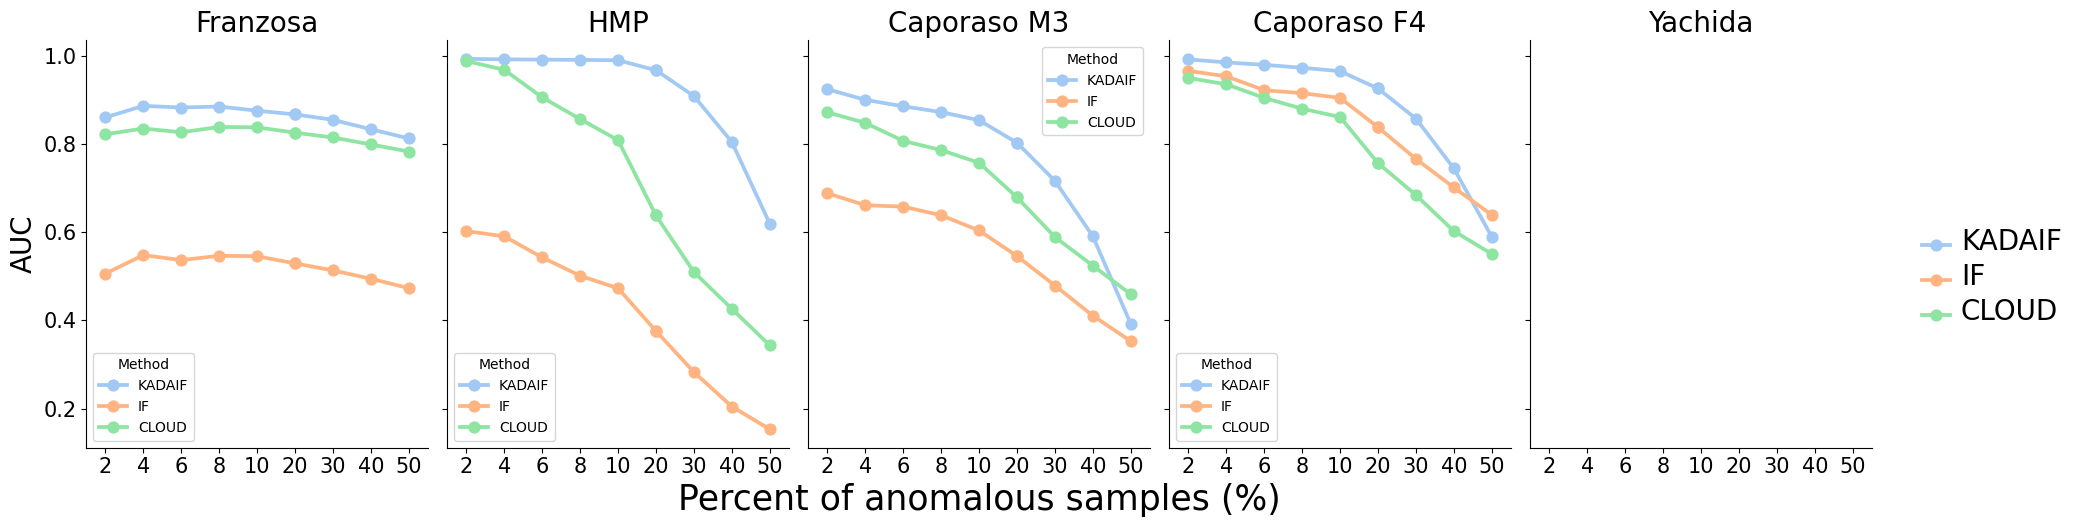

In [48]:
auc_df["Anomaly percentage"] = auc_df["Anomaly percentage"].astype(int)
tmp_auc_df = auc_df[auc_df["Anomaly percentage"] <= 20]
tmp_auc_df2 = auc_df[auc_df["Anomaly percentage"] >= 20]
plt.figure(figsize=(10,20))
g = sns.catplot(x="Anomaly percentage", y="AUC", hue="Method", col="dataset", kind = "point",
                aspect=0.75, palette = "pastel", errorbar = "sd", col_order= ["Franzosa", "HMP", "Caporaso M3", "Caporaso F4", "Yachida"],
               data=tmp_auc_df)

for ax, col_name in zip(g.axes.flat, g.col_names):
    sns.pointplot(
        x="Anomaly percentage", y="AUC", hue="Method", data=tmp_auc_df2[tmp_auc_df2["dataset"] == col_name],
        ax=ax, palette="pastel", errorbar="sd"
    )
    # for anomal_perc in [2,4, 6, 8, 10, 20]:
    #     sns.pointplot(
    #     x="Anomaly percentage", y="AUC", 
    #         data=tmp_auc_df[(tmp_auc_df["dataset"] == col_name) & (tmp_auc_df["Anomaly percentage"] == anomal_perc) & (tmp_auc_df["Method"] == "KADAIF")],
    #         ax=ax,  errorbar="sd", color= palette[anomal_perc]
    # )

g.set_titles("{col_name}", size=20)  # Here, 'col_name' will be replaced by the value of the dataset column


# Increase the font size for the axis ticks
counter = 0
for ax in g.axes.flat:
    ax.tick_params(labelsize= 15)  
    # Increase the axis title size
      # Set the size of the x-axis title
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    if counter == 2:
        ax.set_xlabel("Percent of anomalous samples (%)", fontsize=25)
    else:
        ax.set_xlabel("", fontsize=0)
    counter += 1

    # ax.legend_.remove()
    # ax.axhline(y = 0.5, color = 'r', linestyle = 'dotted', alpha = 0.4) 

plt.ylabel("AUC", fontsize = 20)
    
g._legend.set_title("", prop={'size': 0})
for text in g._legend.texts:
    text.set_fontsize('20')  # Set text fontsize
g._legend.set_bbox_to_anchor((1.05, 0.5))  # Moves the legend to the right of the figure
# for handle in g._legend.legendHandles:
    # handle.set_sizes([50])  # Optionally add a frame around the legend

# for ax, (col_name, subset_data) in zip(g.axes.flat, auc_df.groupby('dataset')):
#     groups = ["KADAIF"]
#     colors = sns.color_palette("husl", len(groups))  # Choose a color palette
    
#     for group, color in zip(groups, colors):
#         group_data = subset_data[subset_data['Method'] == group].groupby(by = ["dataset",  "Method", "num_of_anomalies"]).mean()
#         for i in range(group_data.shape[0]):
#             ax.plot(group_data["AUC"].iloc[i], group_data["Anomaly percentage"].iloc[i], size = 1000)
# ax.scatter(data = group_data,
        #     x = 'Anomaly percentage', 
        #     y = 'AUC', 
        #     color=color, 
        #     zorder=3  # Ensure points are above lines
        # )
        
    # Optionally, you can add the legend per subplot



# plt.gcf().text(-0.025, 0.98, 'A', fontsize=40, fontweight='bold', ha='left', va='top')



plt.savefig(r"D:\אוניברסיטה\מעבדה\Project - Maya\figures\research_proposal.jpg", bbox_inches='tight', dpi=1000)
plt.show()

In [49]:
only_anomalies = depth_df[depth_df["anomaly"]]
only_norms = depth_df[~depth_df["anomaly"]]
only_norms = only_norms[only_norms["anomaly_precentage"] == 2]
only_norms["anomaly_precentage"] = "Normal"

anomalies_norms_concat = pd.concat([only_anomalies, only_norms])
anomalies_norms_concat = anomalies_norms_concat[~anomalies_norms_concat["anomaly_precentage"].isin([30, 40, 50])]

<Figure size 1000x2000 with 0 Axes>

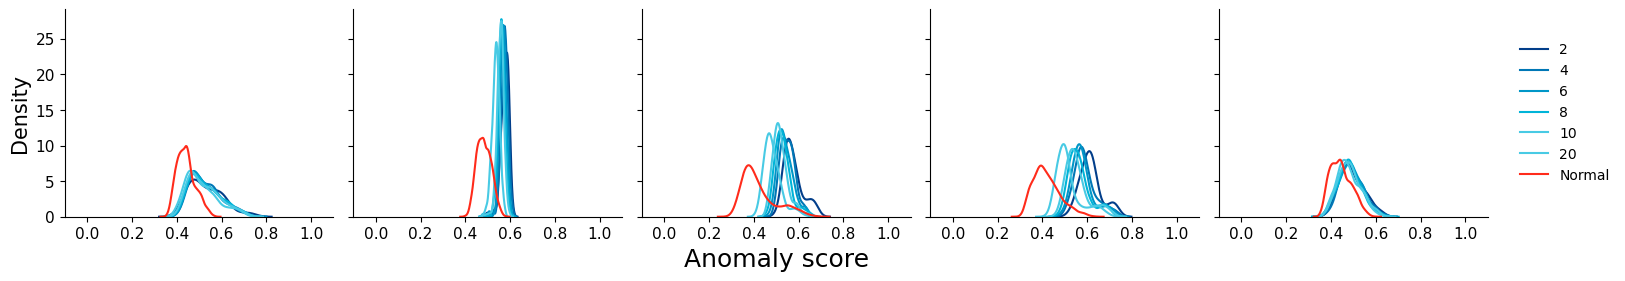

In [58]:
### palette https://coolors.co/palette/03045e-023e8a-0077b6-0096c7-00b4d8-48cae4-90e0ef-ade8f4-caf0f8
plt.figure(figsize=(10,20), constrained_layout=True)

g = sns.FacetGrid(data = anomalies_norms_concat, col="dataset", hue = "anomaly_precentage", 
                  palette = palette,
                  col_order= ["Franzosa", "HMP", "Caporaso M3", "Caporaso F4", "Wang"]
                 )
g.map(sns.kdeplot, "score")
plt.legend(frameon=False, prop={'size': 15}).set_bbox_to_anchor((1.7, 1.4))
plt.ylabel("Density", fontsize = 20)

counter = 0
g.set_titles("", size = 14)
for ax in g.axes.flat:
    ax.get_xaxis().set_ticks([0,0.2,0.4,0.6,0.8, 1])
    ax.tick_params(labelsize= 11)  
    ax.set_xlim(-0.1, 1.1)

    # Increase the axis title size
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    if counter == 2:
        ax.set_xlabel("Anomaly score", fontsize=18)
    else:
        ax.set_xlabel("", fontsize=0)
    counter += 1
# plt.gcf().text(-0.02, 1, 'B', fontsize=29, fontweight='bold', ha='left', va='top')
# plt.figure(figsize=size)
ax.legend(bbox_to_anchor=(1.5, 0.9), frameon=False)
plt.savefig(r"D:\אוניברסיטה\מעבדה\Project - Maya\figures\fig2B_1000dpi_only_two.jpg", bbox_inches='tight', dpi = 1000)
plt.show()
# sns.lineplot(data = auc_df, x = "num_of_anomalies", y = "score", hue = "mifo_iso")

In [27]:
only_anomalies = depth_df[depth_df["anomaly"]]
only_norms = depth_df[~depth_df["anomaly"]]
only_norms["anomaly_precentage"] = [f"Normal {cur_anomaly_perc}%" for cur_anomaly_perc in only_norms["anomaly_precentage"]]

anomalies_norms_concat = pd.concat([only_anomalies, only_norms])
anomalies_norms_concat = anomalies_norms_concat[~anomalies_norms_concat["anomaly_precentage"].isin([30, 40, 50, "Normal 30%", "Normal 40%", "Normal 50%"])]


C:\Users\Omri\AppData\Local\Temp\ipykernel_44748\876257577.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_norms["anomaly_precentage"] = [f"Normal {cur_anomaly_perc}%" for cur_anomaly_perc in only_norms["anomaly_precentage"]]


<Figure size 1000x2000 with 0 Axes>

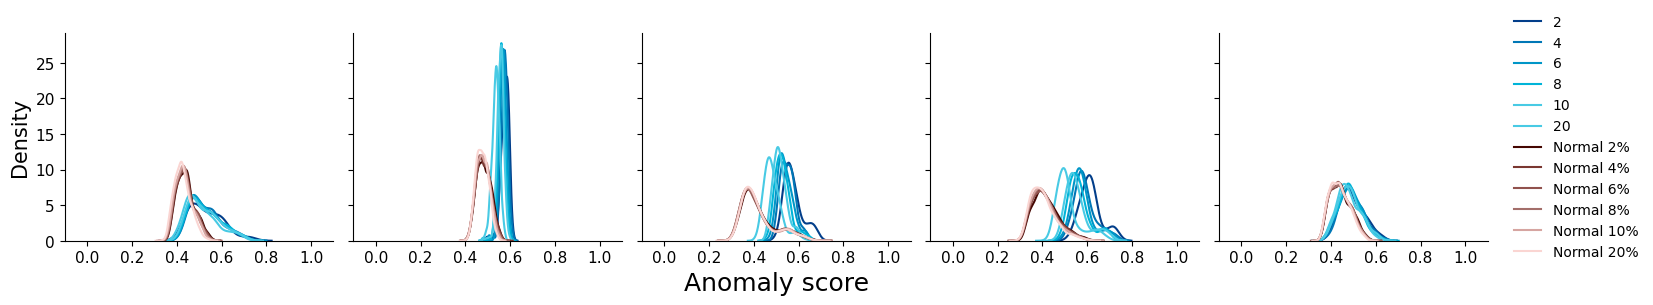

In [44]:
### palette https://coolors.co/palette/03045e-023e8a-0077b6-0096c7-00b4d8-48cae4-90e0ef-ade8f4-caf0f8
plt.figure(figsize=(10,20), constrained_layout=True)

g = sns.FacetGrid(data = anomalies_norms_concat, col="dataset", hue = "anomaly_precentage", 
                  palette = palette,
                  col_order= ["Franzosa", "HMP", "Caporaso M3", "Caporaso F4", "Wang"]
                 )
g.map(sns.kdeplot, "score")
plt.legend(frameon=False, prop={'size': 15}).set_bbox_to_anchor((1.7, 1.4))
plt.ylabel("Density", fontsize = 20)

counter = 0
g.set_titles("", size = 14)
for ax in g.axes.flat:
    ax.set_xlim(-0.1, 1.1)
    ax.get_xaxis().set_ticks([0,0.2,0.4,0.6,0.8, 1])
    ax.tick_params(labelsize= 11)  

    # Increase the axis title size
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    if counter == 2:
        ax.set_xlabel("Anomaly score", fontsize=18)
    else:
        ax.set_xlabel("", fontsize=0)
    counter += 1
# plt.gcf().text(-0.02, 1, 'B', fontsize=29, fontweight='bold', ha='left', va='top')
# plt.figure(figsize=size)
ax.legend(bbox_to_anchor=(1.05, 1.15), frameon=False)
plt.savefig(r"D:\אוניברסיטה\מעבדה\Project - Maya\figures\figSXX_distribution_with_all_1000dpi.jpg", 
bbox_inches='tight', dpi = 1000)
plt.show()
# sns.lineplot(data = auc_df, x = "num_of_anomalies", y = "score", hue = "mifo_iso")

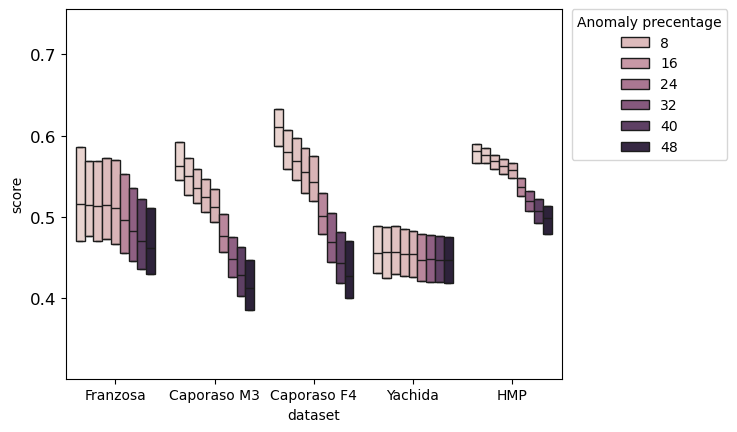

In [10]:
sns.boxplot(data = depth_df[depth_df["anomaly"]], x = "dataset", y = "score", hue = "anomaly_precentage", whis = 0,
           fliersize = 0)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = "Anomaly precentage")
plt.rcParams.update({'font.size': 17}) 
plt.yticks(fontsize=12)  # Y-axis ticks font size
plt.show()

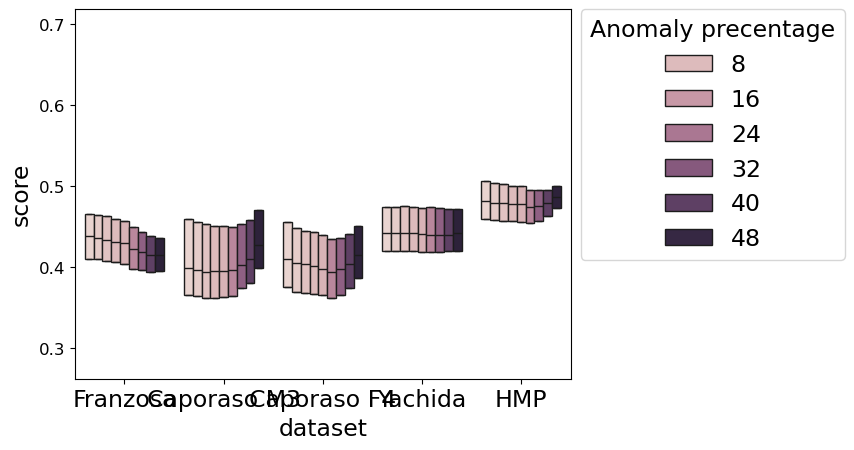

In [11]:
sns.boxplot(data = depth_df[~depth_df["anomaly"]], x = "dataset", y = "score", hue = "anomaly_precentage", whis = 0,
           fliersize = 0)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = "Anomaly precentage")
plt.rcParams.update({'font.size': 17}) 
plt.yticks(fontsize=12)  # Y-axis ticks font size

plt.show()